# This comes after CLAIRS calling; both extra filtering the calls and plotting


In [1]:
library(data.table)
library(tidyverse)
library(ggplot2)
library(UpSetR)
library(ggsci)
library(cowplot)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()

In [ ]:
setwd("/signature.tools.lib/")

In [3]:
library(devtools)

Loading required package: usethis



In [5]:
library(BSgenome.Hsapiens.UCSC.hg38)

Loading required package: GenomeInfoDb



Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:lubridate’:

    second, second<-


The

In [7]:
samples <- c("D0", "Q1", "Q2", "Q3")

In [ ]:
# Create file paths dynamically


file_paths <- paste0("/CLAIRS_TO/coverage_10/", 
                     samples, "/snv.vcf.gz")
# Read and label each file with its timepoint
vcf_list <- mapply(function(file, sample) {
  dt <- fread(file, skip = "#CHROM")
  dt <- dt[FILTER == "PASS"]  # Filter only PASS
  
  # Extract the genotype/sample column (assume it's column 10 for now)
  sample_col <- names(dt)[10]  # or replace with exact sample column name if known
  
  # Separate FORMAT fields into new columns
  dt <- dt %>%
    mutate(sample_data = as.character(get(sample_col))) %>%
    separate(sample_data, into = c("GT", "GQ", "DP", "AF", "AD", "AU", "CU", "GU", "TU"), sep = ":") %>%
    mutate(timepoint = sample)
  
  return(as.data.table(dt))
}, file_paths, samples, SIMPLIFY = FALSE)

In [9]:
colnames(vcf_list[[1]])

[1] "#CHROM"    "POS"       "ID"        "REF"       "ALT"       "QUAL"     
 [7] "FILTER"    "INFO"      "FORMAT"    "D0"        "GT"        "GQ"       
[13] "DP"        "AF"        "AD"        "AU"        "CU"        "GU"       
[19] "TU"        "timepoint"

In [11]:
# Combine all into one long dataframe
df_long <- bind_rows(vcf_list) %>%
  select(`#CHROM`, POS, timepoint, QUAL, DP, AF) %>%
  mutate(present = 1) 

In [12]:
setDT(df_long)

Here we are going apply the filter condition: more strict if only in 1 sample

In [13]:
# Assuming df_long is already a data.table
df_long[, variant := paste(`#CHROM`, POS, sep = ":")]

# Count how many unique samples each variant appears in
variant_counts <- df_long[, .(sample_count = uniqueN(timepoint)), by = variant]

# Merge count info back
df_long <- merge(df_long, variant_counts, by = "variant")

# Apply filtering condition
df_filtered <- df_long[sample_count >= 2 | (sample_count == 1 & QUAL > 25 & DP > 30 & AF > 0.15)]

# Extract metadata (e.g., CHROM, POS, QUAL)
meta <- unique(df_filtered[, .(variant, `#CHROM`, POS, QUAL)])

In [14]:
wide_presence <- dcast(
  df_filtered[, .(variant, timepoint, present = 1)], 
  variant ~ timepoint, 
  value.var = "present", 
  fill = 0
)

# Merge metadata back
df_wide <- merge(meta, wide_presence, by = "variant")

# Reorder columns (optional)
setcolorder(df_wide, c("variant", "#CHROM", "POS", "QUAL"))

In [16]:
df_wide <- df_wide[!duplicated(df_wide$variant), ]

In [17]:
df_wide 

variant,#CHROM,POS,QUAL,D0,Q1,Q2,Q3
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr10:100239175,chr10,100239175,60.7878,0,0,0,1
chr10:100244609,chr10,100244609,15.6850,1,1,1,1
chr10:100274928,chr10,100274928,87.1612,1,1,0,1
chr10:100504513,chr10,100504513,64.8268,1,1,1,1
chr10:100554396,chr10,100554396,65.9101,1,1,1,1
chr10:100574852,chr10,100574852,65.1676,1,1,1,1
chr10:100588309,chr10,100588309,54.9513,1,0,1,1
chr10:100596807,chr10,100596807,53.0938,1,1,1,0
chr10:100646858,chr10,100646858,65.1122,0,1,0,1


In [18]:
list_variants = c("chr13:28028203","chr12:28028203","chr12:25245347","chr12:25225628","chr12:112450406","chr12:112450395","chr4:112450395","chr4:1961074","chr1:1961074","chr1:114716123","chr1:114716126","chr16:28936152","chr16:28935555","chr16:28935556")

In [19]:
CD19 <- df_wide[df_wide$variant %in% list_variants, ]
CD19

variant,#CHROM,POS,QUAL,D0,Q1,Q2,Q3
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr12:112450395,chr12,112450395,62.4684,1,1,1,1
chr12:25245347,chr12,25245347,52.7211,0,1,1,1
chr16:28935556,chr16,28935556,55.9252,0,0,0,1
chr16:28936152,chr16,28936152,25.8363,0,0,0,1
chr4:1961074,chr4,1961074,21.6985,1,1,1,1


In [20]:
# Collapse duplicates per variant
sample_cols <- c("D0", "Q1", "Q2", "Q3")

dt <- as.data.table(df_wide)  # assuming your table is called df_wide

# Collapse by variant using max
dt_unique <- dt[, lapply(.SD, max), by = variant, .SDcols = sample_cols]

# Add total presence
dt_unique[, total := rowSums(.SD), .SDcols = sample_cols]

# Initialize list
upset_data <- list()

# Unique variants per sample
for (s in sample_cols) {
  upset_data[[s]] <- dt_unique[get(s) == 1 & total == 1, .N]
}

# Combinations of samples
for (i in 2:length(sample_cols)) {
  combs <- combn(sample_cols, i, simplify = FALSE)
  for (c in combs) {
    combo_name <- paste(c, collapse = "&")
    sub_dt <- dt_unique[, ..c]
    count <- sum(rowSums(sub_dt == 1) == i & dt_unique$total == i)
    upset_data[[combo_name]] <- count
  }
}

# Build data.frame
upset_df <- data.frame(
  set_name = names(upset_data),
  count = unlist(upset_data),
  stringsAsFactors = FALSE
)

In [21]:
upset_df

,set_name,count
,<chr>,<int>
D0,D0,1419
Q1,Q1,1185
Q2,Q2,3183
Q3,Q3,2485
D0&Q1,D0&Q1,857
D0&Q2,D0&Q2,892
D0&Q3,D0&Q3,849
Q1&Q2,Q1&Q2,1679
Q1&Q3,Q1&Q3,1266


In [22]:
input <- setNames(upset_df$count, upset_df$set_name)

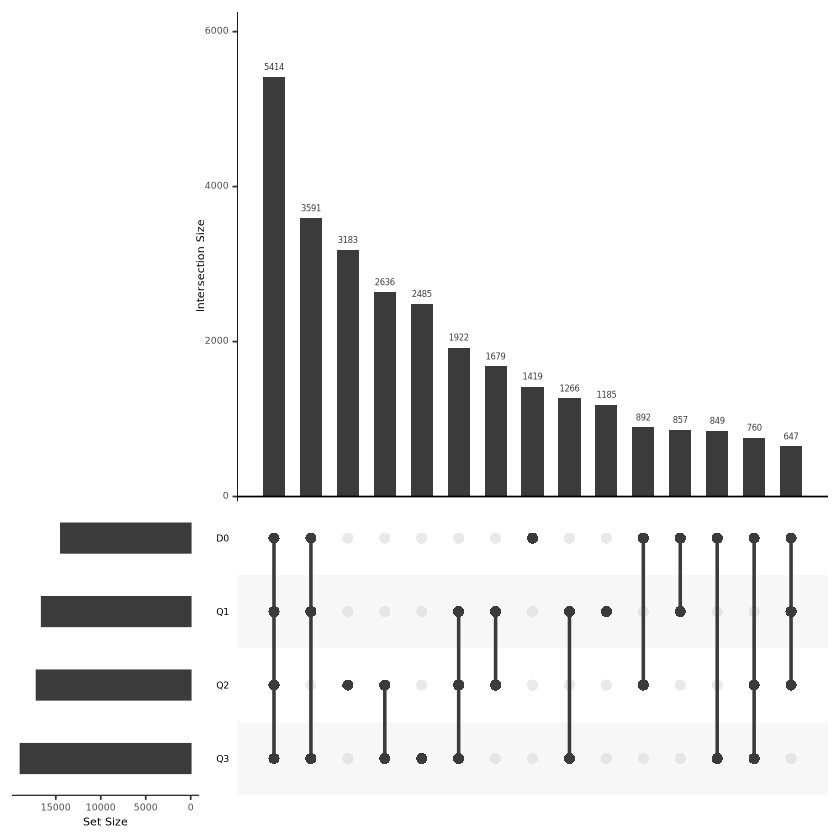

In [26]:
upset(fromExpression(input), 
      nintersects = 40,  # Show top 40 intersections
      nsets = 6,  # Show 6 sample sets in the plot
      order.by = "freq",  # Order intersections by frequency (most common first)
      decreasing = T,  # Show largest groups first
      mb.ratio = c(0.6, 0.4),  # Adjust plot ratio (Main bars vs Matrix plot)
      number.angles = 0,  # Keep intersection size labels horizontal
      text.scale = 0.8,  # Increase text size
      point.size = 2.8,  # Adjust dot size in the matrix
      line.size = 1  # Adjust connecting line size
)


In [38]:
setwd("/staging/leuven/stg_00096/home/projects/2023_Cools_B-ALL/FINAL_DNA_ANALYSIS/new_Variant_calling/")

In [39]:
# Save to PDF
pdf("upset_plot_snv.pdf", width = 10, height = 6)

upset(fromExpression(input), 
      nintersects = 40,      # Show top 40 intersections
      nsets = 6,             # Show 6 sample sets in the plot
      order.by = "freq",     # Order intersections by frequency (most common first)
      decreasing = TRUE,     # Show largest groups first
      mb.ratio = c(0.6, 0.4),# Adjust plot ratio
      number.angles = 0,     # Horizontal labels
      text.scale = 0.8,      # Text size
      point.size = 2.8,      # Dot size
      line.size = 1          # Line size
)

dev.off()

pdf 
  2

Write a loci.txt -> switch depending on the sample you want and re-run this next part again for each sample:

In [40]:
sample <- "Q3"

In [ ]:
# Switch to the right list for each sample as well!!!
vcf <- vcf_list[[4]]
vcf

#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,Q3,GT,GQ,DP,AF,AD,AU,CU,GU,TU,timepoint
<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr1,58952,.,A,G,14.6705,PASS,FAU=5;FCU=0;FGU=2;FTU=0;RAU=8;RCU=0;RGU=2;RTU=0;SB=1.0,GT:GQ:DP:AF:AD:AU:CU:GU:TU,"0/1:14:17:0.2353:13,4:13:0:4:0",0/1,14,17,0.2353,"13,4",13,0,4,0,Q3
chr1,60541,.,A,G,10.0087,PASS,H;FAU=5;FCU=0;FGU=1;FTU=0;RAU=9;RCU=0;RGU=2;RTU=0;SB=1.0,GT:GQ:DP:AF:AD:AU:CU:GU:TU,"0/1:10:17:0.1765:14,3:14:0:3:0",0/1,10,17,0.1765,"14,3",14,0,3,0,Q3
chr1,62304,.,T,C,17.2842,PASS,H;FAU=0;FCU=2;FGU=0;FTU=7;RAU=0;RCU=1;RGU=0;RTU=5;SB=1.0,GT:GQ:DP:AF:AD:AU:CU:GU:TU,"0/1:17:15:0.2000:12,3:0:3:0:12",0/1,17,15,0.2000,"12,3",0,3,0,12,Q3
chr1,128957,.,T,C,22.4832,PASS,H;FAU=0;FCU=2;FGU=0;FTU=8;RAU=0;RCU=3;RGU=0;RTU=10;SB=1.0,GT:GQ:DP:AF:AD:AU:CU:GU:TU,"0/1:22:23:0.2174:18,5:0:5:0:18",0/1,22,23,0.2174,"18,5",0,5,0,18,Q3
chr1,131184,.,T,C,10.7616,PASS,H;FAU=0;FCU=2;FGU=0;FTU=6;RAU=0;RCU=3;RGU=0;RTU=7;SB=1.0,GT:GQ:DP:AF:AD:AU:CU:GU:TU,"0/1:10:18:0.2778:13,5:0:5:0:13",0/1,10,18,0.2778,"13,5",0,5,0,13,Q3
chr1,131817,.,A,G,8.1306,PASS,H;FAU=7;FCU=0;FGU=2;FTU=0;RAU=7;RCU=0;RGU=2;RTU=0;SB=1.0,GT:GQ:DP:AF:AD:AU:CU:GU:TU,"0/1:8:18:0.2222:14,4:14:0:4:0",0/1,8,18,0.2222,"14,4",14,0,4,0,Q3
chr1,289127,.,G,A,14.2460,PASS,H;FAU=2;FCU=0;FGU=12;FTU=0;RAU=1;RCU=0;RGU=5;RTU=0;SB=1.0,GT:GQ:DP:AF:AD:AU:CU:GU:TU,"0/1:14:20:0.1500:17,3:3:0:17:0",0/1,14,20,0.1500,"17,3",3,0,17,0,Q3
chr1,289745,.,T,C,9.1576,PASS,H;FAU=0;FCU=2;FGU=0;FTU=18;RAU=0;RCU=1;RGU=0;RTU=8;SB=1.0,GT:GQ:DP:AF:AD:AU:CU:GU:TU,"0/1:9:29:0.1034:26,3:0:3:0:26",0/1,9,29,0.1034,"26,3",0,3,0,26,Q3
chr1,617409,.,A,C,20.6958,PASS,FAU=0;FCU=6;FGU=0;FTU=0;RAU=0;RCU=8;RGU=0;RTU=0;SB=1.0,GT:GQ:DP:AF:AD:AU:CU:GU:TU,"1/1:20:14:1.0000:0,14:0:14:0:0",1/1,20,14,1.0000,"0,14",0,14,0,0,Q3


In [42]:
D0 <-df_wide[df_wide$Q3 == 1,]

In [43]:
D0

variant,#CHROM,POS,QUAL,D0,Q1,Q2,Q3
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr10:100239175,chr10,100239175,60.7878,0,0,0,1
chr10:100244609,chr10,100244609,15.6850,1,1,1,1
chr10:100244609,chr10,100244609,52.6381,1,1,1,1
chr10:100244609,chr10,100244609,60.8805,1,1,1,1
chr10:100244609,chr10,100244609,18.0215,1,1,1,1
chr10:100274928,chr10,100274928,87.1612,1,1,0,1
chr10:100274928,chr10,100274928,76.9426,1,1,0,1
chr10:100274928,chr10,100274928,66.4493,1,1,0,1
chr10:100504513,chr10,100504513,64.8268,1,1,1,1


In [44]:
# Filter by ref_filtered
 vcf_filtered  <- semi_join(vcf, D0, by = c("#CHROM", "POS"))

In [45]:
head(vcf_filtered)

#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,Q3,GT,GQ,DP,AF,AD,AU,CU,GU,TU,timepoint
<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr1,617409,.,A,C,20.6958,PASS,FAU=0;FCU=6;FGU=0;FTU=0;RAU=0;RCU=8;RGU=0;RTU=0;SB=1.0,GT:GQ:DP:AF:AD:AU:CU:GU:TU,"1/1:20:14:1.0000:0,14:0:14:0:0",1/1,20,14,1.0000,"0,14",0,14,0,0,Q3
chr1,669334,.,A,C,20.6609,PASS,FAU=0;FCU=5;FGU=0;FTU=0;RAU=2;RCU=4;RGU=0;RTU=0;SB=1.0,GT:GQ:DP:AF:AD:AU:CU:GU:TU,"0/1:20:12:0.7500:2,9:2:9:0:0",0/1,20,12,0.7500,"2,9",2,9,0,0,Q3
chr1,941526,.,G,T,63.8137,PASS,H;FAU=0;FCU=0;FGU=39;FTU=34;RAU=0;RCU=0;RGU=37;RTU=39;SB=0.16589,GT:GQ:DP:AF:AD:AU:CU:GU:TU,"0/1:63:149:0.4899:76,73:0:0:76:73",0/1,63,149,0.4899,"76,73",0,0,76,73,Q3
chr1,956183,.,C,T,81.1951,PASS,H;FAU=0;FCU=34;FGU=0;FTU=32;RAU=0;RCU=46;RGU=0;RTU=44;SB=1.0,GT:GQ:DP:AF:AD:AU:CU:GU:TU,"0/1:81:156:0.4872:80,76:0:80:0:76",0/1,81,156,0.4872,"80,76",0,80,0,76,Q3
chr1,965436,.,G,A,61.9883,PASS,FAU=26;FCU=0;FGU=37;FTU=0;RAU=45;RCU=0;RGU=29;RTU=0;SB=0.00769,GT:GQ:DP:AF:AD:AU:CU:GU:TU,"0/1:61:138:0.5145:66,71:71:0:66:0",0/1,61,138,0.5145,"66,71",71,0,66,0,Q3
chr1,1064721,.,A,C,66.9678,PASS,H;FAU=28;FCU=25;FGU=0;FTU=0;RAU=13;RCU=38;RGU=0;RTU=0;SB=0.00338,GT:GQ:DP:AF:AD:AU:CU:GU:TU,"0/1:66:104:0.6058:41,63:41:63:0:0",0/1,66,104,0.6058,"41,63",41,63,0,0,Q3


In [46]:
setwd(paste0("/staging/leuven/stg_00096/home/projects/2023_Cools_B-ALL/FINAL_DNA_ANALYSIS/new_Variant_calling/CLAIRS_TO/coverage_10/",sample,"/"))

In [47]:
loci <- vcf_filtered %>% select ("#CHROM", POS)

In [49]:
fwrite(loci, "loci.txt", col.names = FALSE, sep = '\t')

After this go to 02_filter_vcf_pos.sh for filterig for the final snv vcf

In [7]:
library(maftools)

# MAF script

In [ ]:
OUTBASE <- "/CLAIRS_TO/coverage_10"

In [3]:
print(OUTBASE)

[1] "/staging/leuven/stg_00096/home/projects/2023_Cools_B-ALL/FINAL_DNA_ANALYSIS/new_Variant_calling/CLAIRS_TO/coverage_10"


In [4]:
snv_files <- list.files(OUTBASE, pattern = "maf", full.names = T, recursive = T)
snv_files

[1] "/staging/leuven/stg_00096/home/projects/2023_Cools_B-ALL/FINAL_DNA_ANALYSIS/new_Variant_calling/CLAIRS_TO/coverage_10/D0/D0_PASS_funcotate_snvs_indels.maf"
[2] "/staging/leuven/stg_00096/home/projects/2023_Cools_B-ALL/FINAL_DNA_ANALYSIS/new_Variant_calling/CLAIRS_TO/coverage_10/Q1/Q1_PASS_funcotate_snvs_indels.maf"
[3] "/staging/leuven/stg_00096/home/projects/2023_Cools_B-ALL/FINAL_DNA_ANALYSIS/new_Variant_calling/CLAIRS_TO/coverage_10/Q2/Q2_PASS_funcotate_snvs_indels.maf"
[4] "/staging/leuven/stg_00096/home/projects/2023_Cools_B-ALL/FINAL_DNA_ANALYSIS/new_Variant_calling/CLAIRS_TO/coverage_10/Q3/Q3_PASS_funcotate_snvs_indels.maf"

In [5]:
timepoint <- c("D0", "Q1", "Q2", "Q3")

In [48]:
process_maf_files <- function(maf_files, sample_name) {

  # Read MAF files and update Tumor_Sample_Barcode and matched_mode
  r_maffiles <- lapply(seq_along(maf_files), function(i) {
    maf <- read.maf(maf_files[i])
    maf@data$Tumor_Sample_Barcode <- sample_name[i]
    return(maf)
  })
    # Merge the MAF files into a single cohort
  maf_files_matched_cohort <- merge_mafs(r_maffiles, verbose = TRUE)
  
  return(maf_files_matched_cohort)
}
maf_files_matched_cohort <- process_maf_files(snv_files,sample_name = timepoint)

-Reading
-Validating
-Silent variants: 14310 
-Summarizing
-Processing clinical data
--Missing clinical data
-Finished in 0.152s elapsed (0.704s cpu) 
-Reading
-Validating
-Silent variants: 16421 
-Summarizing
-Processing clinical data
--Missing clinical data
-Finished in 0.180s elapsed (0.764s cpu) 
-Reading
-Validating
-Silent variants: 17032 
-Summarizing
-Processing clinical data
--Missing clinical data
-Finished in 0.162s elapsed (0.774s cpu) 
-Reading
-Validating
-Silent variants: 18773 
-Summarizing
-Processing clinical data
--Missing clinical data
-Finished in 0.181s elapsed (0.874s cpu) 
Merging 4 MAF objects
-Validating
--Removed 37690 duplicated variants
-Silent variants: 28846 
-Summarizing
-Processing clinical data
--Annotation missing for below samples in MAF:
  D0
  Q1
  Q2
  Q3
-Finished in 0.602s elapsed (1.255s cpu) 


In [49]:
maf_files_matched_cohort@data$Tumor_Sample_Barcode

[1] D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0
 [26] D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0
 [51] D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0
 [76] D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0
[101] D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 D0 Q1 Q1 Q1 Q1 Q1 Q1
[126] Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1
[151] Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1
[176] Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1
[201] Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1
[226] Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1
[251] Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q1 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2
[276] Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2
[301] Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2
[326] Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2
[351] Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q2 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3
[376] Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3
[401] Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3
[426] Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3
[451] Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3
[476] Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3
[501] Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3 Q3
Levels: D0 Q1 Q2 Q3 __UNKNOWN__

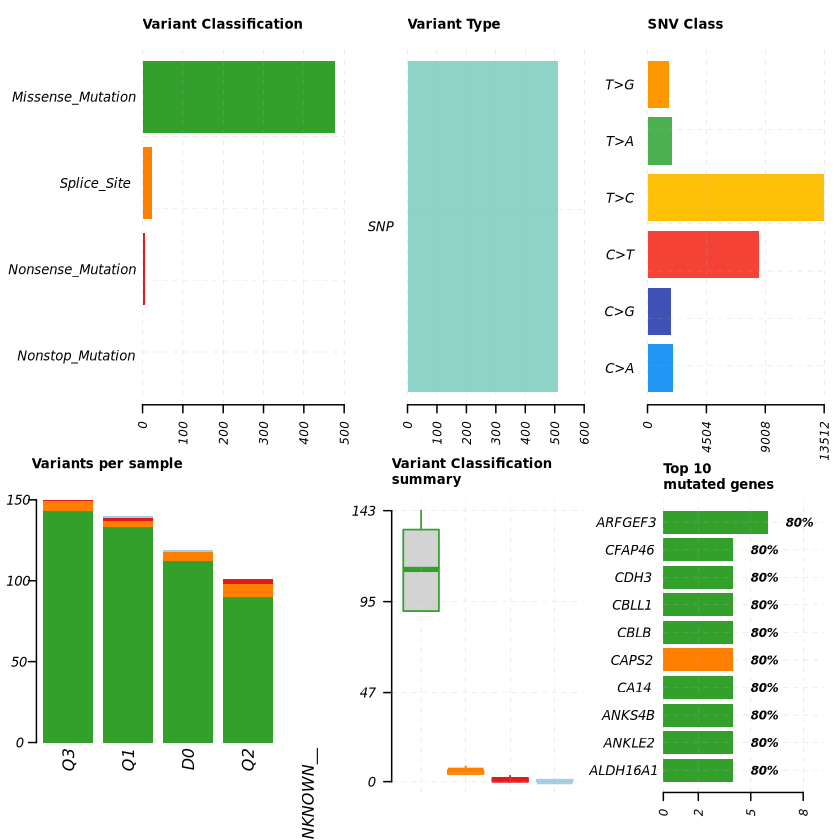

In [50]:
y <- plotmafSummary(maf_files_matched_cohort, showBarcodes = TRUE)

In [53]:
mutations <- c("NRAS", "NSD2", "PTPN11", "KRAS", "FLT3", "CD19" ,"TP53","CDKN2A")

In [56]:
getwd()

[1] "/lustre1/project/stg_00096/home/projects/2023_Cools_B-ALL/FINAL_DNA_ANALYSIS/new_Variant_calling/CLAIRS_TO"

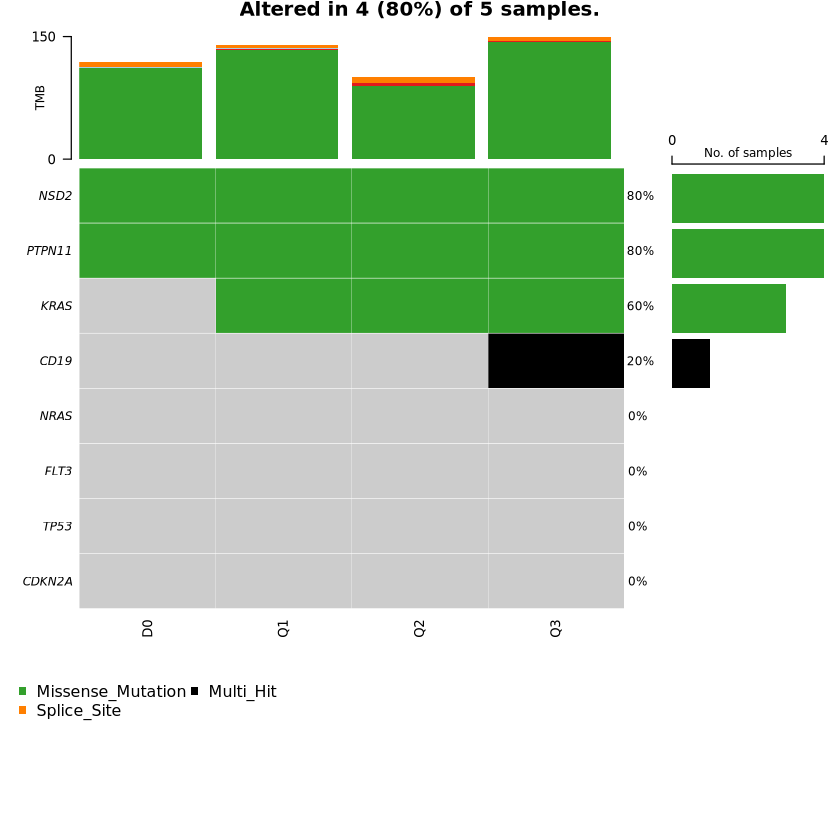

In [55]:
x <- oncoplot(maf =maf_files_matched_cohort, top = 20, fontSize = 0.6, showTumorSampleBarcodes = T, writeMatrix = F, genes = mutations, sampleOrder = c("D0", "Q1","Q2","Q3"))

In [57]:
pdf("oncoplot_top20.pdf", width = 10, height = 8)  # adjust size as needed

oncoplot(
  maf = maf_files_matched_cohort,
  top = 20,
  fontSize = 0.6,
  showTumorSampleBarcodes = TRUE,
  writeMatrix = FALSE,
  genes = mutations,
  sampleOrder = c("D0", "Q1", "Q2", "Q3")
)

dev.off()

pdf 
  2

2 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



     HGNC refseq.ID protein.ID aa.length
   <char>    <char>     <char>     <num>
1: PTPN11 NM_002834  NP_002825       593
2: PTPN11 NM_080601  NP_542168       460


Using longer transcript NM_002834 for now.

Assuming protein change information are stored under column Protein_Change. Use argument AACol to override if necessary.

Removed 9 mutations for which AA position was not available



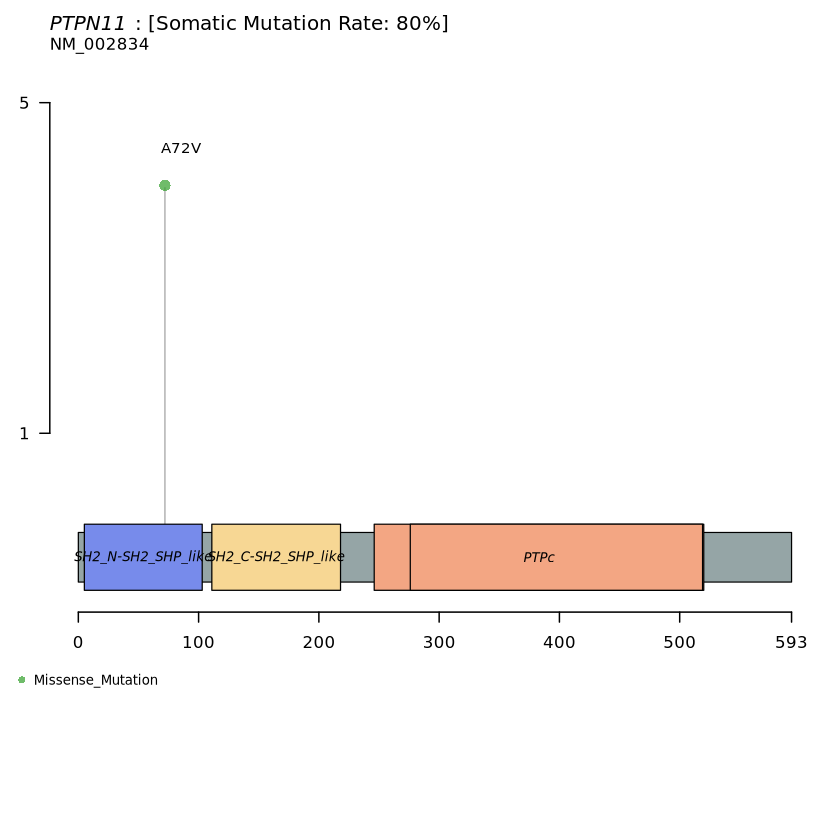

In [24]:
lollipopPlot(
  maf = maf_files_matched_cohort,
  gene = 'PTPN11',
  showMutationRate = TRUE,
  labelPos = c(72)
)

In [58]:
process_maf_files <- function(maf_files, sample_name) {

  # Read MAF files and update Tumor_Sample_Barcode and matched_mode
  r_maffiles <- lapply(seq_along(maf_files), function(i) {
    maf <- read.maf(maf_files[i],vc_nonSyn = c("RNA", "IGR", "5'flank", "Intron", "3'UTR", "Missense_Mutation", "Splice_Site", "Nonsense_Mutation", "In_Frame_Del", "Frame_Shift_Del", "Frame_Shift_Ins", "In_Frame_Ins", "Nonstop_Mutation"))
    maf@data$Tumor_Sample_Barcode <- sample_name[i]
    return(maf)
  })
    # Merge the MAF files into a single cohort
  maf_files_matched_cohort <- merge_mafs(r_maffiles, verbose = TRUE,vc_nonSyn = c("RNA", "IGR", "5'flank", "Intron", "3'UTR", "Missense_Mutation", "Splice_Site", "Nonsense_Mutation", "In_Frame_Del", "Frame_Shift_Del", "Frame_Shift_Ins", "In_Frame_Ins", "Nonstop_Mutation"))
  
  return(maf_files_matched_cohort)
}
maf_files_matched_cohort <- process_maf_files(snv_files,sample_name = timepoint)

-Reading
-Validating
-Silent variants: 1068 
-Summarizing
-Processing clinical data
--Missing clinical data
-Finished in 0.519s elapsed (1.449s cpu) 
-Reading
-Validating
-Silent variants: 1192 
-Summarizing
-Processing clinical data
--Missing clinical data
-Finished in 0.778s elapsed (1.813s cpu) 
-Reading
-Validating
-Silent variants: 926 
-Summarizing
-Processing clinical data
--Missing clinical data
-Finished in 0.522s elapsed (1.544s cpu) 
-Reading
-Validating
-Silent variants: 1261 
-Summarizing
-Processing clinical data
--Missing clinical data
-Finished in 0.597s elapsed (1.755s cpu) 
Merging 4 MAF objects
-Validating
--Removed 2717 duplicated variants
-Silent variants: 1730 
-Summarizing
-Processing clinical data
--Annotation missing for below samples in MAF:
  D0
  Q1
  Q2
  Q3
-Finished in 1.339s elapsed (2.539s cpu) 


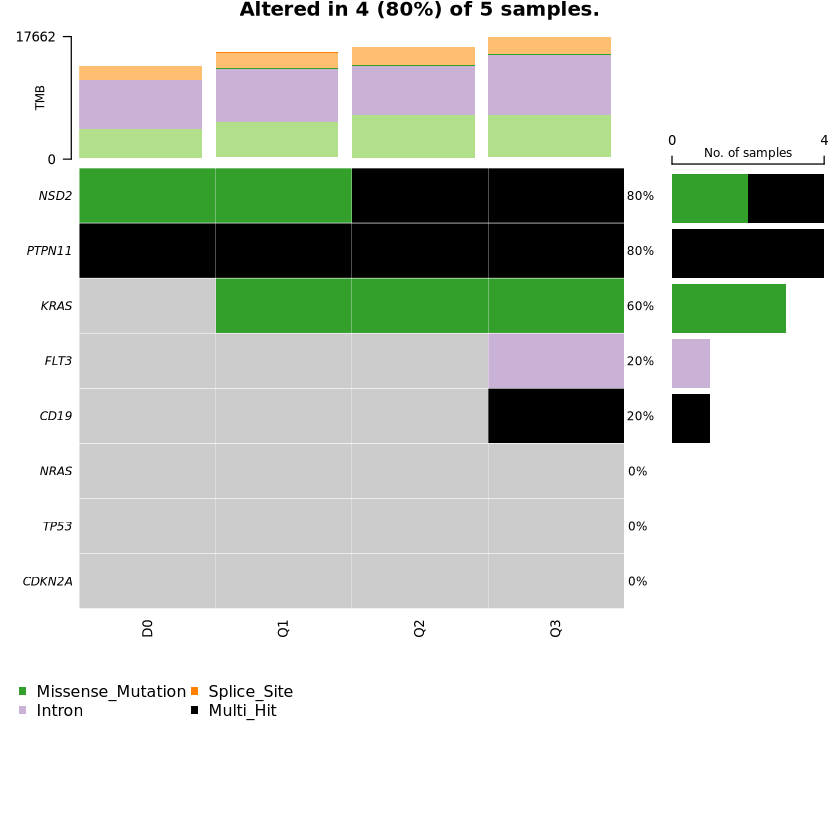

In [59]:
x <- oncoplot(maf =maf_files_matched_cohort, top = 20, fontSize = 0.6, showTumorSampleBarcodes = T, writeMatrix = F, genes = mutations, sampleOrder = c("D0", "Q1","Q2","Q3"))

In [60]:
pdf("oncoplot_TMB.pdf", width = 10, height = 8)  # adjust size as needed

oncoplot(
  maf = maf_files_matched_cohort,
  top = 20,
  fontSize = 0.6,
  showTumorSampleBarcodes = TRUE,
  writeMatrix = FALSE,
  genes = mutations,
  sampleOrder = c("D0", "Q1", "Q2", "Q3")
)

dev.off()


pdf 
  2

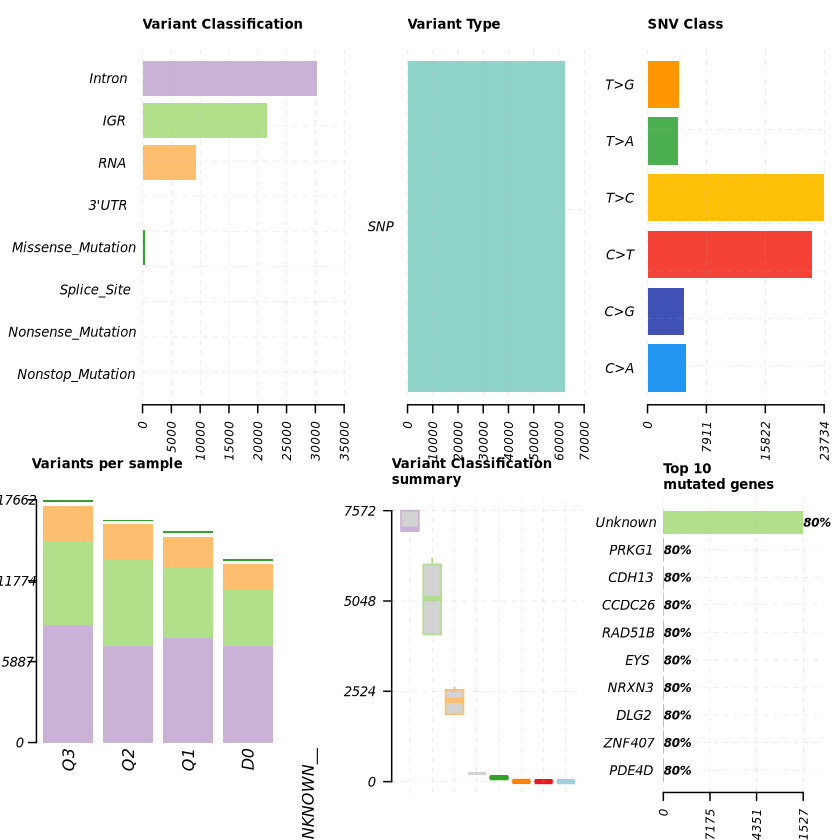

In [19]:
y <- plotmafSummary(maf_files_matched_cohort, showBarcodes = TRUE) + theme_cowplot()

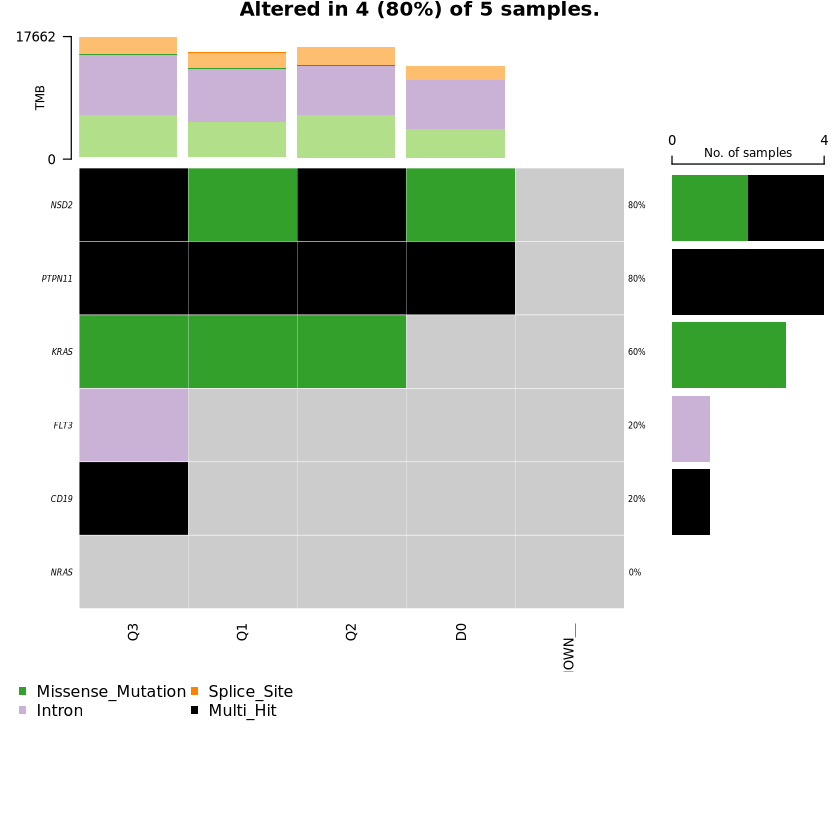

In [20]:
x <- oncoplot(maf =maf_files_matched_cohort, top = 20, fontSize = 0.4, showTumorSampleBarcodes = T, writeMatrix = F, genes = mutations)